In [1]:
from torchvision import models
# from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.pipeline import make_pipeline
import seaborn as sns
from umap.umap_ import UMAP
from sklearn.manifold import TSNE, MDS
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

from torch import flatten, set_num_threads, no_grad, max
import torch.nn as nn
import torch.nn.functional as F

/home/grigorii/bees/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
set_num_threads(8)

In [3]:
random.seed(1)

In [15]:
path = "./data/"
mode = "train/"

In [16]:
path

'./data/train/'

In [16]:
def linear_data(path, mode):
        path = path + mode
        data = []
        labels = []
        folders = ["NORMAL", "PNEUMONIA"]

        for i, folder in enumerate(folders): # agregate data and labels from both folders 
            state_path = path + folder
            for filename in os.listdir(state_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(state_path, filename)
                    img = Image.open(img_path).convert('L') # make monochrome
                    img = img.resize((32, 32)) 
                    img_vector = np.array(img).flatten() # linearization
                    data.append(img_vector)
                    labels.append(i)
        
        archive = list(zip(data, labels)) # combine into a single dataset

        random.shuffle(archive) # randomization

        data, labels = zip(*archive) # unzip

        return np.array(data), np.array(labels)

In [17]:
data, labels = linear_data(path, mode)

In [7]:
data.shape

(5216, 1024)

In [23]:
labels.shape

(5216,)

In [15]:
labels

array([1, 1, 0, ..., 0, 1, 0])

In [18]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data) 

In [19]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_scaled)

In [20]:
tsne = TSNE()
data_tsne = tsne.fit_transform(data_scaled)

In [21]:
umap = UMAP(n_components=2)
data_umap = umap.fit_transform(data_scaled)

/home/grigorii/bees/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0, 0.5, 'PC2')

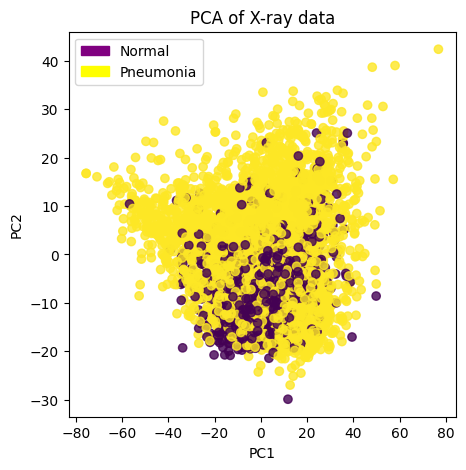

In [18]:
fig, ax = plt.subplots(figsize = (5, 5))
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1],
                alpha = 0.8,
                c = labels)

normal_patch = mpatches.Patch(color='purple', label='Normal')
pneumonia_patch = mpatches.Patch(color='yellow', label='Pneumonia')

ax.legend(handles=[normal_patch, pneumonia_patch], loc='best')

plt.title("PCA of X-ray data", fontsize = 12)
ax.set_xlabel("PC1", fontsize = 10)
ax.set_ylabel("PC2")

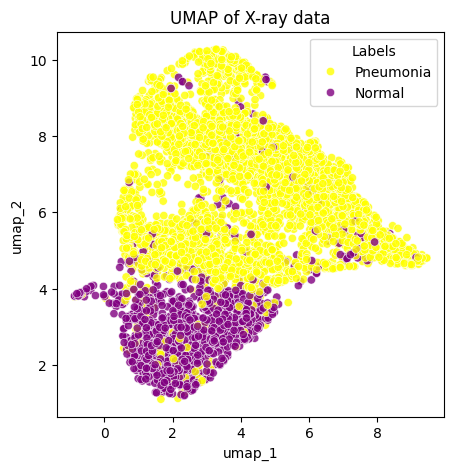

In [24]:
label_mapping = {0: 'Normal', 1: 'Pneumonia'}
palette = {0: 'purple', 1: 'yellow'}

fig, ax = plt.subplots(figsize=(5, 5))

# Create the scatterplot
scatter = sns.scatterplot(
    x=data_umap[:, 0], 
    y=data_umap[:, 1], 
    hue=[label_mapping[label] for label in labels],  # Map numeric labels to strings
    alpha=0.8, 
    palette={'Normal': 'purple', 'Pneumonia': 'yellow'}, 
    ax=ax
)

# Customize the legend
scatter.legend(title='Labels', loc='best')

# Add title and labels
plt.title("UMAP of X-ray data", fontsize=12)
ax.set_xlabel("umap_1", fontsize=10)
ax.set_ylabel("umap_2", fontsize=10)
plt.show()

In [25]:
fig.savefig('./images/umap.png')

Best C for inner CV: 0.1
Best kernel for inner CV: linear
Best score for outer CV: 0.9605062761045172


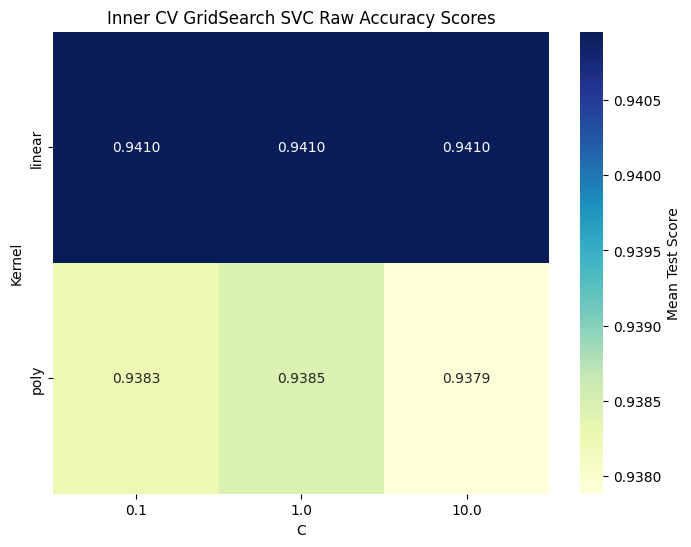

In [22]:
# Declaration of grids
inner_cv = KFold(n_splits = 5, shuffle = True)
outer_cv = KFold(n_splits = 5, shuffle = True)

# Setting models and parameters
params = {"C": [1e-1, 1, 10], "kernel": ['linear', "poly"]}
model = SVC()

# Grid search
search = GridSearchCV(estimator = model, param_grid = params, 
                      n_jobs = -1, cv = inner_cv) 
scores = cross_val_score(search, X = data_scaled, y = labels,
                        cv = outer_cv, n_jobs = -1)

# Visualization
search.fit(data_umap, labels)
results = pd.DataFrame(search.cv_results_)

print(f"Best C for inner CV: {search.best_params_['C']}")
print(f"Best kernel for inner CV: {search.best_params_['kernel']}")
print(f"Best score for outer CV: {scores.mean()}")

pivot_table = results.pivot_table(
    values = 'mean_test_score', 
    index = 'param_kernel', 
    columns = 'param_C'
)

plt.figure(figsize = (8, 6))
sns.heatmap(pivot_table, annot = True, 
            cmap = "YlGnBu", fmt=".4f",
            cbar_kws = {'label': 'Mean Test Score'})
plt.title('Inner CV GridSearch SVC Raw Accuracy Scores')
plt.xlabel('C')
plt.ylabel('Kernel')
plt.savefig('./images/heatmap_grid_accuracy.png')
plt.show()


In [78]:
# Declaration of grids
inner_cv = KFold(n_splits = 5, shuffle = True)
outer_cv = KFold(n_splits = 5, shuffle = True)

# Setting models and parameters
params = {"C": [1e-1, 1, 10], "kernel": ['linear', "poly"]}
model = SVC()

# Grid search
search = GridSearchCV(estimator = model, param_grid = params, 
                      n_jobs = -1, cv = inner_cv, scoring = 'roc_auc') 
umap_scores = cross_val_score(search, X = data_umap, y = labels,
                        cv = outer_cv, n_jobs = -1, scoring = 'roc_auc')

In [32]:
dummy_clf = DummyClassifier(strategy = "most_frequent")

In [74]:
dummy_search = cross_val_score(estimator = dummy_clf, X = data_scaled, y = labels,
                        cv = outer_cv, n_jobs = -1, scoring = 'roc_auc')

In [35]:
dummy_search

array([0.5, 0.5, 0.5, 0.5, 0.5])

In [36]:
scores

array([0.92944418, 0.94982914, 0.94258061, 0.91921553, 0.94565895])

In [80]:
score_table = np.vstack((dummy_search, umap_scores, scores)).T
score_table

array([[0.5       , 0.92135222, 0.98168444],
       [0.5       , 0.9529157 , 0.98783653],
       [0.5       , 0.9392124 , 0.98335863],
       [0.5       , 0.94271383, 0.97890028],
       [0.5       , 0.92822493, 0.98557204]])

In [81]:
score_table = pd.DataFrame(score_table)
score_table.columns = ["Dummy Scores", "UMAP Model Scores", "Raw Model Scores"]
score_table = score_table.melt(var_name = "Model Type", value_name = "Score")

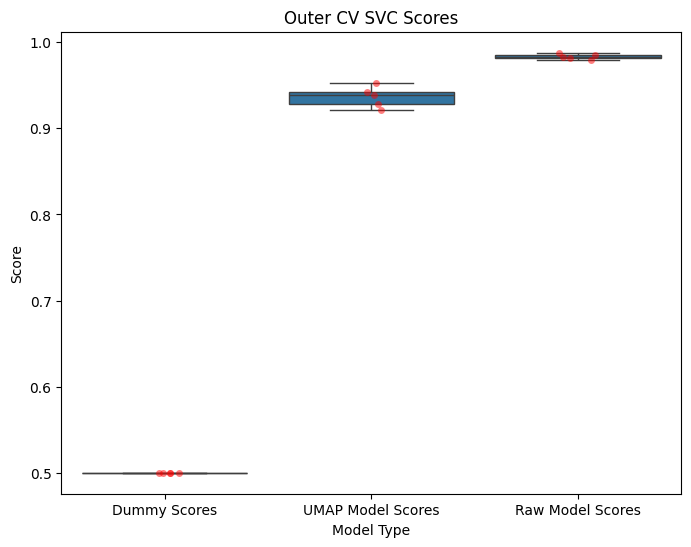

In [82]:
plt.figure(figsize=(8, 6))
sns.boxplot(data = score_table, x = "Model Type", y = "Score")
sns.stripplot(data = score_table, x = "Model Type", y = "Score",
               color='red', alpha=0.5)
plt.title('Outer CV SVC Scores')
plt.ylabel('Score')
plt.savefig('./images/boxplot_models_raw.png')
plt.show()


In [19]:
path = "./data/"

In [121]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels = 1), # make monochrome
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize((0.5), (0.5))  # Normalize to [-1, 1]
])

# Train dataset and dataloader
mode = "train"
trainset = datasets.ImageFolder(root = path + mode, 
                               transform = transform)
trainloader = DataLoader(trainset, batch_size = 100, shuffle = True)
# Test dataset and dataloader
mode = "test"
testset = datasets.ImageFolder(root = path + mode, 
                               transform = transform)
testloader = DataLoader(testset, batch_size = 100, shuffle = True)

In [23]:
trainset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

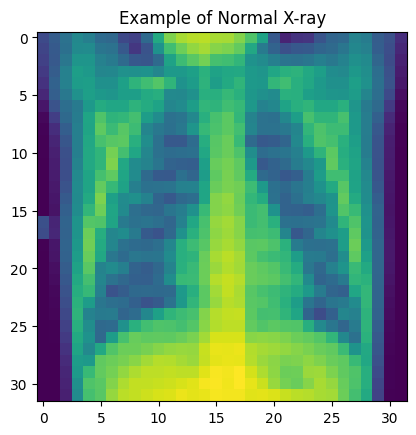

In [122]:
dataiter = iter(trainloader)
idx = trainloader.batch_size - 1
images, labels = next(dataiter)
label = "Normal" if labels[idx] == 0 else "Pneumonia"

img = images[idx] / 2 + 0.5
npimg = img.numpy()

plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title(f"Example of {label} X-ray")
plt.show()

In [123]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(120, 81)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(81, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x
    
net = CNNet()

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [117]:
epochs = 10

[1,    10] loss: 0.577
[1,    20] loss: 0.330
[1,    30] loss: 0.259
[1,    40] loss: 0.186
[1,    50] loss: 0.149
[2,    10] loss: 0.126
[2,    20] loss: 0.133
[2,    30] loss: 0.137
[2,    40] loss: 0.090
[2,    50] loss: 0.100
[3,    10] loss: 0.093
[3,    20] loss: 0.082
[3,    30] loss: 0.090
[3,    40] loss: 0.074
[3,    50] loss: 0.075
[4,    10] loss: 0.069
[4,    20] loss: 0.071
[4,    30] loss: 0.060
[4,    40] loss: 0.092
[4,    50] loss: 0.080
[5,    10] loss: 0.050
[5,    20] loss: 0.036
[5,    30] loss: 0.069
[5,    40] loss: 0.069
[5,    50] loss: 0.051
[6,    10] loss: 0.068
[6,    20] loss: 0.049
[6,    30] loss: 0.083
[6,    40] loss: 0.041
[6,    50] loss: 0.033
[7,    10] loss: 0.061
[7,    20] loss: 0.048
[7,    30] loss: 0.056
[7,    40] loss: 0.037
[7,    50] loss: 0.041
[8,    10] loss: 0.038
[8,    20] loss: 0.040
[8,    30] loss: 0.023
[8,    40] loss: 0.020
[8,    50] loss: 0.026
[9,    10] loss: 0.028
[9,    20] loss: 0.055
[9,    30] loss: 0.038
[9,    40] 

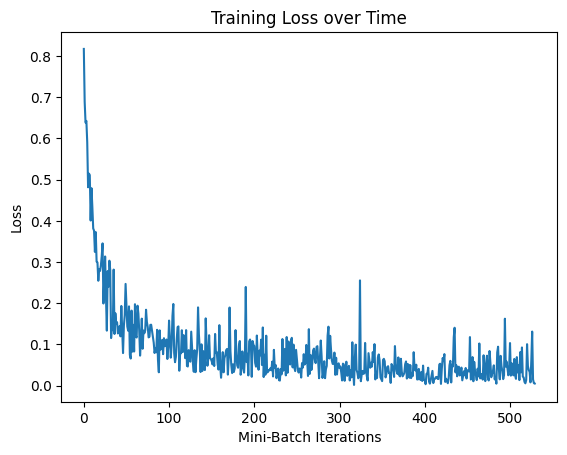

In [125]:
losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs) # forward
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

print('Finished Training')

plt.plot(losses)
plt.xlabel('Mini-Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

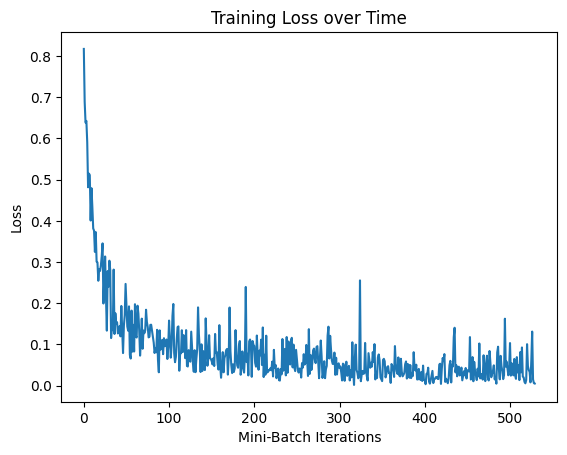

In [126]:
plt.plot(losses)
plt.xlabel('Mini-Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.savefig("./images/simple_cnn_final.png")
plt.show()

In [127]:
correct = 0
total = testset.__len__()

with no_grad(): # torch.no_grad
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = max(outputs, 1) # torch.max
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 624 test images: {100 * correct // total} %')
        

Accuracy of the network on the 624 test images: 75 %


In [138]:
resnet = models.resnet18(pretrained=True)

/home/grigorii/bees/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/grigorii/bees/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [134]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize((0.5), (0.5))  # Normalize to [-1, 1]
])

# Train dataset and dataloader
mode = "train"
trainset = datasets.ImageFolder(root = path + mode, 
                               transform = transform)
trainloader = DataLoader(trainset, batch_size = 100, shuffle = True)
# Test dataset and dataloader
mode = "test"
testset = datasets.ImageFolder(root = path + mode, 
                               transform = transform)
testloader = DataLoader(testset, batch_size = 100, shuffle = True)

In [143]:
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

for param in resnet.fc.parameters():
    param.requires_grad = True

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters())

In [145]:
epochs = 10
train_losses = []
test_losses = []
accuracy_list = []

In [ ]:
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs, labels

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(trainloader))
    
    # Evaluate on test data
    resnet.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs, labels
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / len(testloader))
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

print("Finished Training")



Epoch 1/10 - Train Loss: 0.1071, Test Loss: 1.0464, Accuracy: 75.16%
Epoch 2/10 - Train Loss: 0.0184, Test Loss: 1.0635, Accuracy: 74.68%
Epoch 3/10 - Train Loss: 0.0166, Test Loss: 1.0948, Accuracy: 75.64%
Epoch 4/10 - Train Loss: 0.0170, Test Loss: 1.1995, Accuracy: 75.00%
Epoch 5/10 - Train Loss: 0.0169, Test Loss: 1.3158, Accuracy: 74.68%
Epoch 6/10 - Train Loss: 0.0156, Test Loss: 1.1337, Accuracy: 75.00%


In [1]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.savefig('./images/res_loss_freeze.png')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.savefig('./images/res_acc_freeze.png')
plt.show()

NameError: name 'plt' is not defined